# Smoothing

This notebook shows how to use `dysh` to smooth a spectrum.   For the example below we will use data from the Position-Switch example. The following dysh commands are the simplest to get and smooth a spectrum (leaving out all the function arguments):

      sdf = GBTFITSLoad()
      sb = sdf.getps()
      ta = sb.timeaverage()
      tb = ta.smooth()
      tb.plot()

or if you wish to make use of the Python object chaining:

       GBTFITSLoad().getps().timeaverage().smooth().plot()
      

In [1]:
from pathlib import Path
from dysh.util.download import from_url
from dysh.fits.gbtfitsload import GBTFITSLoad

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)

In [4]:
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.343112,18.64274
1,52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.930571,18.787219
2,53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.330491,18.356075
3,54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.915725,18.492742
4,55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.304237,18.057533
5,56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.890603,18.186034
6,57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.327548,17.385267
7,58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.919161,17.494902


## Data Reduction

### Calibration and Time Averaging

This test data has 8 scans making up 4 pairs of OnOff observations. We will calibrate all of the OnOff scan pairs, time average them and then compare the results with and without smoothing. To calibrate all of the scans, we can omit the scan keyword when using the `sdfits.getps` method.

*Technical note*: ``getps`` returns a **ScanBlock** with in this case four `PSScan`s, since there are four pairs of OnOff observations.


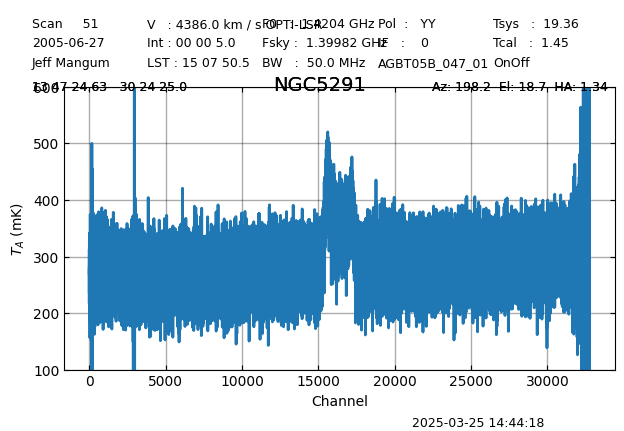

Stats : mean: 0.2708 K median: 0.2711 K rms: 0.0359 K min: 0.14 K max: 0.42 K
Expect: mean: 0.2708 K median: 0.2711 K rms: 0.0359 K min: 0.14 K max: 0.42 K


In [5]:
scan_block = sdfits.getps(ifnum=0, plnum=0, fdnum=0)
ta = scan_block.timeaverage()
ta.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=100, ymax=600, grid=True)

# Define a string for printing the spectrum statistics.
fmt_str = "mean: {mean:.4f} median: {median:.4f} rms: {rms:.4f} min: {min:.2f} max: {max:.2f}"
print(f"Stats : {fmt_str}".format(**ta[5000:14000].stats()))
print("Expect: mean: 0.2708 K median: 0.2711 K rms: 0.0359 K min: 0.14 K max: 0.42 K")

The noise in the time averaged spectrum is 36 mK. However, this has not been baseline subtracted and there is a slope in the continuum.

### Baseline Removal

We remove the slope by baseline fitting an order 1 polynomial from the data while ignoring the channels that contain a signal. This is done using the `Spectrum.baseline()` method.

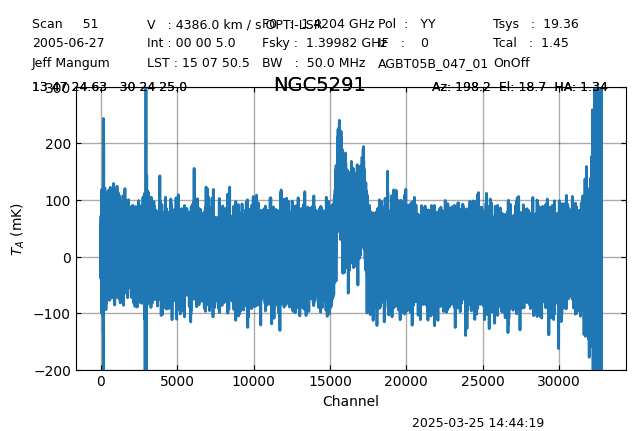

Stats : mean: 0.0005 K median: 0.0005 K rms: 0.0358 K min: -0.13 K max: 0.16 K
Expect: mean: 0.0005 K median: 0.0005 K rms: 0.0358 K min: -0.13 K max: 0.16 K


In [6]:
ta.baseline(model="poly", degree=1, exclude=[(14000,18000)], remove=True)
ta.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)
print(f"Stats : {fmt_str}".format(**ta[5000:14000].stats()))
print("Expect: mean: 0.0005 K median: 0.0005 K rms: 0.0358 K min: -0.13 K max: 0.16 K")

### Smooth in a Few Ways

By default smoothing will also decimate the signal, to (roughly) make each channel independant of the next. This assuming the input signal had independant channels. If the input was oversampled by a factor of 2, the smoothed signal will be as well, although you can manually decimate by a different value too, for example by using ``decimate=8`` .

Since we smooth to a gauss of FWHM 16 channels, the noise should go down by a factor of 4 (36 mK to 9 mK).

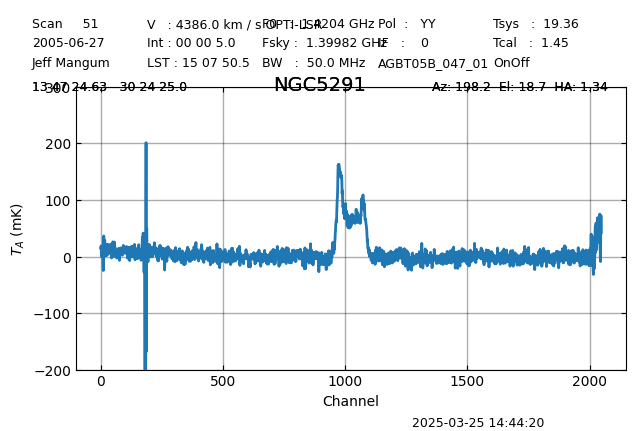

Stats : mean: 0.0005 K median: 0.0004 K rms: 0.0075 K min: -0.02 K max: 0.03 K
Expect: mean: 0.0005 K median: 0.0004 K rms: 0.0075 K min: -0.02 K max: 0.03 K


In [7]:
ts1 = ta.smooth('gaussian', 16)
ts1.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)
print(f"Stats : {fmt_str}".format(**ts1[5000//16:14000//16].stats()))
print("Expect: mean: 0.0005 K median: 0.0004 K rms: 0.0075 K min: -0.02 K max: 0.03 K")

The noise is now 8 mK, very close to the improvement we expected.

Now smoothing by 320 channels should result in a noise of $55/\sqrt{320}$ or 2 mK. In this case we will use a box as the convolving kernel.

We will also estimate the correlation between channels by comparing the noise in the spectra with the noise in the spectra when we subtract adjacent channels (using `roll=1` in `Spectrum.stats()`).

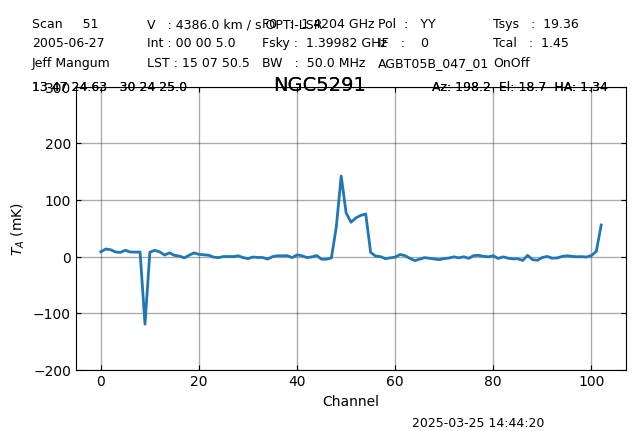

Stats : mean: 0.0006 K median: 0.0004 K rms: 0.0024 K min: -0.00 K max: 0.01 K
Rolled rms/rms ratio: 1.0617949879772322


In [8]:
ts2 = ta.smooth('box', 320)
ts2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)

print(f"Stats : {fmt_str}".format(**ts2[5000//320:14000//320].stats()))
rratio = ts2[5000//320:14000//320].stats(roll=1)["rms"]/ts2[5000//320:14000//320].stats(roll=0)["rms"]
print(f"Rolled rms/rms ratio: {rratio}")

The noise in the smoothed spectrum is ~2 mK, as expected.

The rolled RMS ratio is very close to 1, so neighboring channels are not related. If you would decimate by 160, you would see this ratio drop. Be sure to adjust the range of channels for any new computations of the spectrum statistics (`Spectrum.stats`).

### Smoothing the Reference ("OFF") Scans

Under certain circumstances it can be beneficial to (boxcar) smooth the reference (OFF) signal before the usual
(ON-OFF)/OFF calibration. 

*Technical note*:  if you want to achieve identical results to GBTIDL, the width of the boxcar needs to be odd.


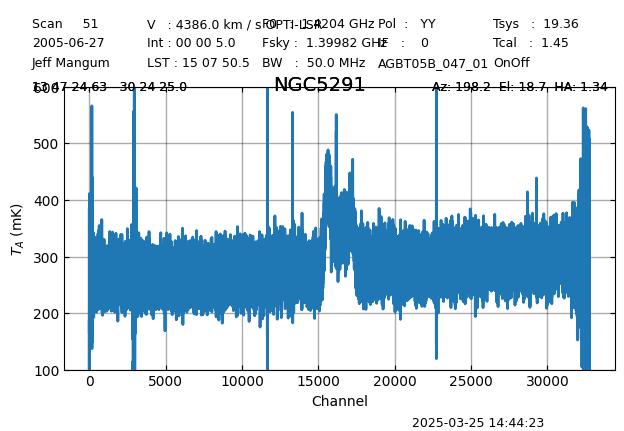

Stats : mean: 0.2694 K median: 0.2690 K rms: 0.0272 K min: 0.08 K max: 0.78 K
Expect: mean: 0.2694 K median: 0.2690 K rms: 0.0272 K min: 0.08 K max: 0.78 K


In [9]:
scan_block2 = sdfits.getps(ifnum=0, plnum=0, fdnum=0, smoothref=31)
ta2 = scan_block2.timeaverage()
ta2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=100, ymax=600, grid=True)
print(f"Stats : {fmt_str}".format(**ta2[5000:14000].stats()))
print("Expect: mean: 0.2694 K median: 0.2690 K rms: 0.0272 K min: 0.08 K max: 0.78 K")

When smoothing the reference spectra, the noise in the time average of the calibrated spectrum is 27 mK.

We repeat the baseline subtraction using the same model.

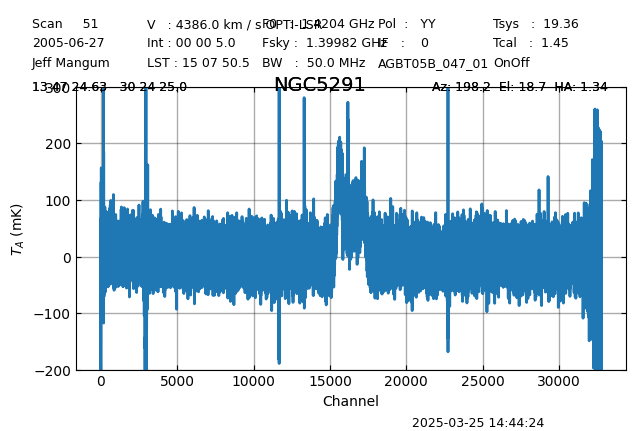

Stats : mean: 0.0009 K median: 0.0007 K rms: 0.0270 K min: -0.19 K max: 0.50 K
Expect: mean: 0.0009 K median: 0.0007 K rms: 0.0270 K min: -0.19 K max: 0.50 K


In [10]:
ta2.baseline(model="poly", degree=1, exclude=[(14000,18000)], remove=True)
ta2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)
print(f"Stats : {fmt_str}".format(**ta2[5000:14000].stats()))
print("Expect: mean: 0.0009 K median: 0.0007 K rms: 0.0270 K min: -0.19 K max: 0.50 K")

We could smooth this spectrum the normal way, as was done a few cells ago, and not much difference is visible, except for the noise.

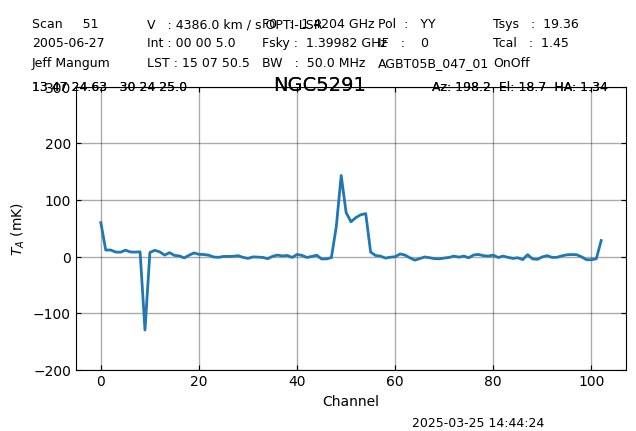

Stats : mean: 0.0009 K median: 0.0007 K rms: 0.0023 K min: -0.00 K max: 0.01 K
Rolled rms/rms ratio: 1.1034594637813646


In [11]:
ts3 = ta2.smooth('box', 320)
ts3.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)
print(f"Stats : {fmt_str}".format(**ts3[5000//320:14000//320].stats()))
rratio = ts3[5000//320:14000//320].stats(roll=1)["rms"]/ts3[5000//320:14000//320].stats(roll=0)["rms"]
print(f"Rolled rms/rms ratio: {rratio}")

The RMS has gone down (2.4 mK to 2.3 mK), but the signal correlation has also increased from 1.06 to 1.10. This increase is due to the added correlation of the reference smoothing.

## Successive Smoothing

Smoothing with a Gaussian twice in a row should be the same as smoothing with a single Gaussian of the square root of the sum of their squares. Note that the **width** is the final width (FWHM) of the smoothing operation. We need to ignore decimation here, which is the third argument (`decimate=-1`), otherwise the spectra will have a different number of channels.

We plot the difference between the two smoothing routes, which is perhaps surprisingly still below 1e-8. It is not closer to 0 due to the finite range the Gaussian is sampled (to 4 sigma).

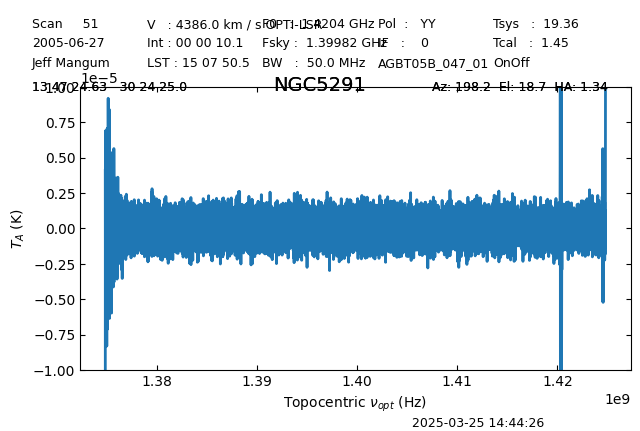

Stats : mean: -2.945e-10 K median: 4.285e-09 K rms: 7.291e-07 K min: -2.8e-06 K max: 2.7e-06 K


In [12]:
ts5a = ta.smooth('gaussian', width=3, decimate=-1).smooth('gaussian', width=5, decimate=-1)
ts5b = ta.smooth('gaussian', width=5, decimate=-1)
diff = ts5a-ts5b
diff.plot(ymin=-0.00001, ymax=0.00001)

fmt_str = "mean: {mean:.4g} median: {median:.4g} rms: {rms:.4g} min: {min:.2g} max: {max:.2g}"
print(f"Stats : {fmt_str}".format(**diff[5000:14000].stats()))